# Classification
 

In [ ]:
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

## Preprocessing
In the following code we update the scores for the final dataset that has been annotated by multiple people to have a score of 1 or 0. 

In [ ]:

# FUNCT 1: Alla håller med
def all_agrees(val):
    parts = [int(x) for x in val.split("/")]
    
    if parts.count(0) == len(parts):
        return 0
    elif parts.count(1) == len(parts):
        return 1
    else:
        return -1
        
# FUNC 2: Alla utom -1 håller med
def all_but_minus(val):
    parts = [int(x) for x in val.split("/")]
    cnt0 = parts.count(0)
    cnt1 = parts.count(1)

    if cnt0 > 0 and cnt1 == 0: 
        return 0
    elif cnt1 > 0 and cnt0 == 0:
        return 1
    else:
        return -1

# FUNCT 3: De flesta håller med
def most_agrees(val):
    parts = [int(x) for x in val.split("/")]    
    if parts.count(0) > len(parts) / 2: 
        return 0
    elif parts.count(1) > len(parts) / 2:
        return 1
    else:
        return -1

def read_data(path, scoring):
    data = pd.read_csv(path, sep="\t", header=0)
    data.columns = ['score', 'text']    
    data['score'] = data.score.apply(scoring)
    data = data[data.score != -1]
    return data

# Pandas for the three annotation summarization options and test data
pd_all_agrees = read_data("a3_train_final.tsv", all_agrees)
pd_all_but_minus = read_data("a3_train_final.tsv", all_but_minus)
pd_most_agrees = read_data("a3_train_final.tsv", most_agrees)
pd_test = read_data("a3_test_final.tsv", lambda x: x)


## Training

In [ ]:
def train_model(data, clf):
    X_train, X_test, Y_train, Y_test = train_test_split(data['text'], data['score'], test_size=0.2, random_state=12345)
    clf.fit(X_train, Y_train)
    clf_acc = accuracy_score(Y_test, clf.predict(X_test))
    return clf_acc

def evaluate_model(train, test, clf):
    X_train, Y_train = train['text'], train['score']
    X_test, Y_test = test['text'], test['score']
    clf.fit(X_train, Y_train)
    clf_acc = accuracy_score(Y_test, clf.predict(X_test))
    return clf_acc    

In [ ]:
# Print scores with default hyperparameters
vectorizer = TfidfVectorizer()
classifier = SGDClassifier()
clf = make_pipeline( vectorizer, classifier )
print("SGDClassifier")
print("Best acc: %lf" %(train_model(pd_most_agrees, clf)))
print("Best test: %lf" %(evaluate_model(pd_most_agrees, pd_test, clf)))

classifier = LinearSVC()
clf = make_pipeline( vectorizer, classifier )
print("LinearSVC")
print("Best acc: %lf" %(train_model(pd_most_agrees, clf)))
print("Best test: %lf" %(evaluate_model(pd_most_agrees, pd_test, clf)))

SGDClassifier
Best acc: 0.849348
Best test: 0.877412
LinearSVC
Best acc: 0.845916
Best test: 0.880817


## Tweaking hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
import warnings

# Ignore some warnings to avoid bloated stdout when using grid search for classifiers
# ignore ConvergeneWarning to avoid convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
# ignore FitFailedWarning to avoid printing errors for grid search at invalid parameter combination
warnings.filterwarnings("ignore", category=FitFailedWarning)
# ignore UserWarning when using grid search for classifier
warnings.filterwarnings("ignore", category=UserWarning)

def make_grid(pipe, params):
    grid = GridSearchCV(pipe, params, cv=5)
    grid.fit(pd_most_agrees['text'],pd_most_agrees['score'])
    return grid  

### Grid search hyperparameters for vectorizer

In [ ]:
# Grid search hyperparameters for vectorizer
params = {
    'vectorizer__ngram_range': [(1,1), (1,2), (2,2)],
    'vectorizer__max_features': [40000, 50000, 60000],
    'vectorizer__max_df': [1.0, 0.9, 0.8],
    'vectorizer__min_df': [1, 5, 10],
    'vectorizer__strip_accents': ['ascii', 'unicode', None]}


pipe = Pipeline([('vectorizer', TfidfVectorizer()),('model', SGDClassifier())])
gridSGD = make_grid(pipe, params)

print("SGDClassifier")
print(gridSGD.best_params_)

pipe = Pipeline([('vectorizer', TfidfVectorizer()),('model', LinearSVC())])
gridSVC = make_grid(pipe, params)

print("LinearSVC")
print(gridSVC.best_params_)

SGDClassifier
{'vectorizer__max_df': 0.8, 'vectorizer__max_features': 50000, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2), 'vectorizer__strip_accents': 'unicode'}
LinearSVC
{'vectorizer__max_df': 1.0, 'vectorizer__max_features': 60000, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2), 'vectorizer__strip_accents': None}


In [ ]:
print(gridSVC.best_estimator_.steps[0])
print(gridSGD.best_estimator_.steps[0])

('vectorizer', TfidfVectorizer(max_features=60000, ngram_range=(1, 2)))
('vectorizer', TfidfVectorizer(max_df=0.8, max_features=50000, ngram_range=(1, 2),
                strip_accents='unicode'))


### Use parameters found in previous grid search (for vectorizer) as argument in grid search for classifiers

In [ ]:
# Best vectorizers from grid search
SGDvectorizer = gridSGD.best_estimator_.steps[0]
LSCVectorizer = gridSVC.best_estimator_.steps[0]
pipes = [
    Pipeline([SGDvectorizer,('model', SGDClassifier())]),
    Pipeline([LSCVectorizer,('model', LinearSVC())])]

params = [{    
    'model__penalty': ["l2", "l1", "elasticnet"],
    'model__loss': ["hinge", "modified_huber", "squared_hinge", "log", "perceptron"],
    'model__alpha': [0.0001],
    'model__max_iter': [1000, 2000, 3000],
    'model__tol': [1e-5, 1e-4, 1e-3, 1e-2]},    
{    
    'model__penalty': ["l2", "l1"],
    'model__max_iter': [1000, 2000, 3000],
    'model__tol': [1e-5, 1e-4, 1e-3, 1e-2],
}]

grids = [make_grid(pipe,param) for pipe,param in zip(pipes, params)]

# print best parameters after tuning 
for grid in grids:
    print(type(grid.estimator.steps[1][1]).__name__)
    print(grid.best_params_)

SGDClassifier
{'model__alpha': 0.0001, 'model__loss': 'modified_huber', 'model__max_iter': 2000, 'model__penalty': 'l2', 'model__tol': 1e-05}
LinearSVC
{'model__max_iter': 1000, 'model__penalty': 'l2', 'model__tol': 1e-05}


## Evaluation

### Test accuracy, training accuracy, precision, recall and f1-scores

In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate

for grid in grids:    
    # print classification report 
    grid_predictions = grid.predict(pd_test['text'])       
    print(type(grid.estimator.steps[1][1]).__name__)
    print(classification_report(pd_test['score'], grid_predictions)) 
        
    scores = cross_validate(grid.best_estimator_, pd_most_agrees['text'], pd_most_agrees['score'])
    print("Training accuracy is %s" %(scores["test_score"].mean() ))


SGDClassifier
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       440
           1       0.89      0.90      0.89       441

    accuracy                           0.89       881
   macro avg       0.89      0.89      0.89       881
weighted avg       0.89      0.89      0.89       881

Training accuracy is 0.8510219141655717
LinearSVC
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       440
           1       0.89      0.90      0.89       441

    accuracy                           0.89       881
   macro avg       0.89      0.89      0.89       881
weighted avg       0.89      0.89      0.89       881

Training accuracy is 0.8512279109503915


### Confusion matricies

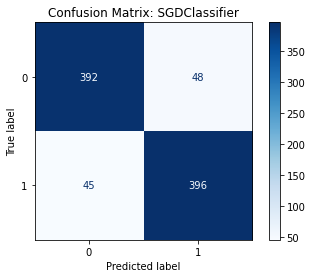

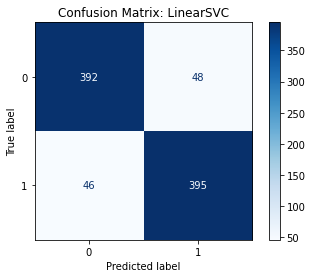

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

class_names = [0, 1]

# Plot non-normalized confusion matrix
for grid in grids:            
    disp = plot_confusion_matrix(grid, pd_test['text'],pd_test['score'], display_labels=class_names, cmap=plt.cm.Blues)
    disp.ax_.set_title("Confusion Matrix: " + type(grid.estimator.steps[1][1]).__name__)
    plt.show()

### Important features

In [ ]:
# Create panda with feature names and importances for each grid

for grid in grids:    
    data = pd.DataFrame()
    data['feat names'] = grid.best_estimator_.steps[0][1].vocabulary_
    data['feat importance'] = grid.best_estimator_.steps[1][1].coef_[0]

    ## Then sort the panda by feature importance and print
    data.sort_values(by='feat importance', ascending=False, inplace=True)
    print(type(grid.estimator.steps[1][1]).__name__)
    print(data)

SGDClassifier
                        feat names  feat importance
really made            really made         2.248226
coronavirus they  coronavirus they         2.213368
th8s                          th8s         2.208323
so hostile              so hostile         2.084440
mutant strains      mutant strains         1.976118
...                            ...              ...
soreness in            soreness in        -2.028790
is behind                is behind        -2.247390
at deaths                at deaths        -2.357352
some were                some were        -2.910171
autism there          autism there        -3.275162

[50000 rows x 2 columns]
LinearSVC
                      feat names  feat importance
brothers                brothers         2.438965
in sight                in sight         2.327989
who dont                who dont         2.314742
waiting my            waiting my         2.234384
pfizer tomorrow  pfizer tomorrow         2.077953
...                       

### Testing random inputs

In [ ]:
Y = [
    "and contribute",
    "\" NATURAL IMMUNITY \" protected us since evolution. Do not exist anymore?", 
    "I do not believe in this vaccine garbage",
    "care how",
    "care how religious beliefs"
    "it scary",    
    "Hello my name is bob and god bless vaccines",
    "I like to become an astronaut when i grow up"]

for grid in grids:
    print( grid.best_estimator_.predict(Y) )   	


[1 0 0 0 0 1 1]
[1 0 0 0 0 1 1]


### Error analysis

In [ ]:

import numpy as np

# SGDvectorizer = TfidfVectorizer(max_df=1.0, max_features=50000, min_df= 1, ngram_range=(1, 2),strip_accents='unicode')
SGDvectorizer = gridSGD.best_estimator_.steps[0][1]
SGDvectorizer.fit(pd_most_agrees['text'])

predic = pd.DataFrame()
predic['predict'] = grid.predict(pd_test['text']) 
predic['true'] = pd_test['score']
predic['text'] = pd_test['text']
errors = predic.loc[predic['predict'] != predic['true']]

print(errors)

def get_top_tf_idf_words(feature_names,response, top_n=2):
    sorted_nzs = np.argsort(response.data)[:-(top_n+1):-1]
    return feature_names[response.indices[sorted_nzs]]

def print_top(text, n):
    response = SGDvectorizer.transform(text)
    feature_names = np.array(SGDvectorizer.get_feature_names())
    print(get_top_tf_idf_words(feature_names,response,n))

def print_error(index, n=3):
    print("--- Printing error ---")
    print(errors.loc[index, 'text'])
    print("predicted value: %d, true value: %d" %(errors.loc[index, 'predict'], errors.loc[index, 'true']))
    text = [errors.loc[index, 'text']]
    print("Top %d important features: " %(n))
    print_top(text, n)
    print()

print_error(32)
print_error(855)
print_error(875)

     predict  true                                               text
18         1     0  About 4 months ago, I had COVID-19. I just got...
28         1     0  Alright, so now look into the covid protein sp...
31         0     1  An infected teacher standing up projecting the...
32         0     1  And a vaccine literally introduces the virus t...
37         0     1  Anti-vaxers chose to believe the lie because t...
..       ...   ...                                                ...
854        0     1      the vaccine is developed by a trusted company
855        0     1  there's a 0.0000000001% chance that I will cho...
862        0     1               vaccine has been clinically verified
869        0     1  vaccines can resist the harm caused by the new...
875        1     0  “Anti-vaxers” are just more intelligent than t...

[94 rows x 3 columns]
--- Printing error ---
And a vaccine literally introduces the virus to your immune system in a non harmful way... Good food doesn't produ

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6196fcd5-7df7-4362-896b-eb198c1ac5ff' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>